# [NeurIPS 2025] Multi-modal Contrastive Learning Adapts to Intrinsic Dimensions of Shared Latent Variables

---
**Authors:** Yu Gui, Cong Ma, Zongming Ma

**Paper:** [arXiv:2505.12473](https://arxiv.org/abs/2505.12473)

**Code (Jupyter Notebook):** Jinwoo Lee (cinescope@kaist.ac.kr)

---

### **Description**
This notebook reproduces the synthetic experiments from **Section 1.1** of the paper, alongside additional empirical results corresponding to **Figures 2, 6, 7, 8, and 9**

It empirically validates how maximizing the InfoNCE loss with a learnable temperature $\tau$ shapes the geometry of learned representations:

1. **Intrinsic Dimension Adaptation ($d \to k^*$):** The model automatically ignores noise dimensions and recovers the true low-dimensional latent structure ($k^*$), even when the output dimension ($d$) is set much higher (e.g., recovering a 2D plane within a 20D space).
2.  **Alignment vs. Uniformity:** The experiments challenge the standard view that contrastive learning simply pursues **uniformity** on the entire output hypersphere ($\mathbb{S}^{d-1}$). Instead, the results demonstrate that representations concentrate on a **lower-dimensional submanifold** (dimension $k^*$), achieving uniformity only within that intrinsic support rather than the full ambient space.
3. **Norm Concentration:** Figures 6 and 8 confirm that representation norms naturally concentrate during training, justifying the paper's theoretical use of population-level normalization.
4.  **Dimension Adaptation without Alignment (Figure 9):** It reproduces the critical case where the function class is restricted (2-layer ReLU) such that perfect alignment is impossible ($\mathcal{V}(\mathcal{H}) = \emptyset$). In this setting, the model fails to align positive pairs (resulting in orthogonal representations, similarity $\approx 0$) but **still correctly adapts to the intrinsic dimension** ($k^*=2$). This proves that intrinsic dimension adaptation is a fundamental property of InfoNCE minimization, occurring even when semantic alignment fails .

In [4]:
pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.6 MB/s eta 0:00:00


## 1-1. A motivating example: CLIP adapts to intrinsic dimension (Section 1.1)
- Refer to Figure 2 in Gui et al., 2025

Starting training (Mode: Population Norm)...


100%|██████████| 600/600 [06:09<00:00,  1.62it/s]


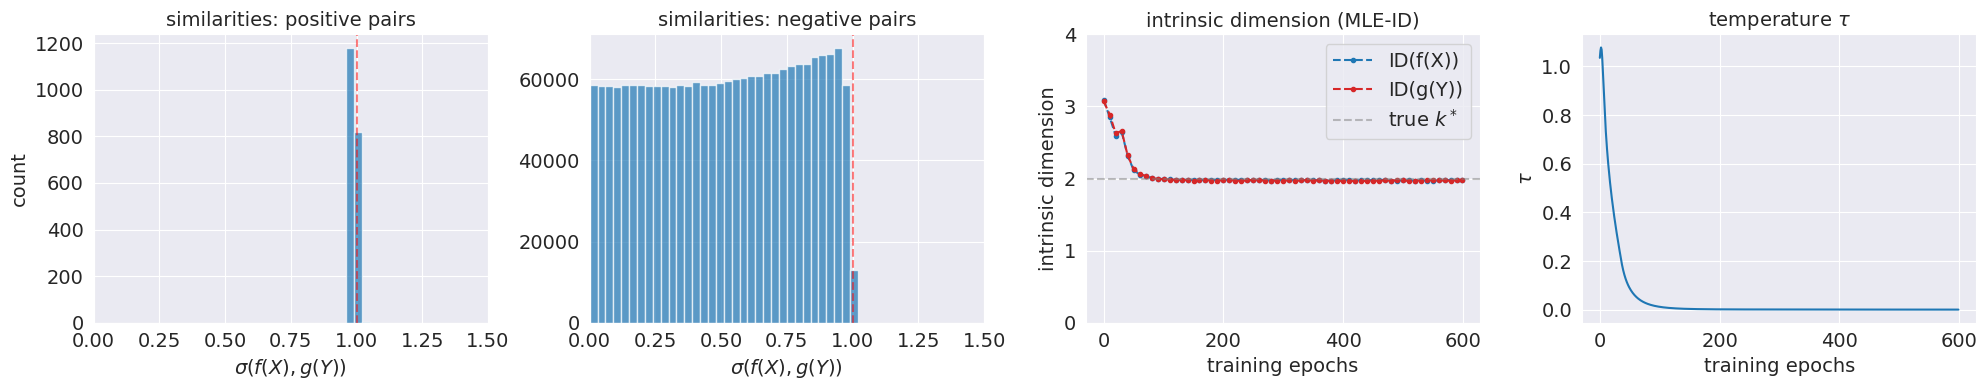

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Import skdim for Intrinsic Dimension estimation
try:
    from skdim.id import MLE
except ImportError:
    raise ImportError("Please install scikit-dimension: pip install scikit-dimension")

# --- 1. Configuration & Hyperparameters ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# True: 일반적인 Cosine Similarity 사용
# False: 논문의 Population-level Normalization 사용
USE_COSINE_SIM = False

# Dimensions
D1 = 20      # Input dim X
D2 = 20      # Input dim Y
K_STAR = 2   # Shared intrinsic dim (Target)
D_OUT = 3    # Output dimension (d > k*)

# Training Settings
N_TOTAL = 14000
N_TEST = 2000
N_NORM_EST = 2000 # Subset for norm estimation
N_TRAIN = N_TOTAL - N_TEST - N_NORM_EST

BATCH_SIZE = 256
EPOCHS = 600

# Learning Rates (Appendix G.3)
LR_NET = 1e-4
LR_TAU = 1e-3
WEIGHT_DECAY = 1e-4

# --- 2. Data Generation (Section 1.1) ---
def generate_synthetic_data(n_samples):
    # Yi ~ N(0, I_d2)
    Y = torch.randn(n_samples, D2)

    # Xi shares first k* components with Yi
    # The rest (d1 - k*) are independent noise
    xi_noise = torch.randn(n_samples, D1 - K_STAR)

    # Construct X: First k* cols are Y[:, :k*], rest are noise
    X_shared = Y[:, :K_STAR]
    X = torch.cat([X_shared, xi_noise], dim=1)

    return X.to(device), Y.to(device)

# --- 3. Model Architecture (Section 1.1) ---
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 논문의 5-layer 구조 유지하되, 학습 안정성을 위해 BatchNorm 추가
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.BatchNorm1d(50),  # [추가] Norm stabilization

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# --- 4. Initialization ---
X_all, Y_all = generate_synthetic_data(N_TOTAL)

# Split datasets
X_norm = X_all[:N_NORM_EST]
Y_norm = Y_all[:N_NORM_EST]
X_test = X_all[N_NORM_EST : N_NORM_EST + N_TEST]
Y_test = Y_all[N_NORM_EST : N_NORM_EST + N_TEST]
X_train = X_all[N_NORM_EST + N_TEST:]
Y_train = Y_all[N_NORM_EST + N_TEST:]

f_model = Encoder(D1, D_OUT).to(device)
g_model = Encoder(D2, D_OUT).to(device)
log_tau = nn.Parameter(torch.tensor(0.0)) # exp(0) = 1.0

optimizer = optim.AdamW([
    {'params': f_model.parameters(), 'lr': LR_NET},
    {'params': g_model.parameters(), 'lr': LR_NET},
    {'params': [log_tau], 'lr': LR_TAU}
], weight_decay=WEIGHT_DECAY)

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Metrics Storage
history = {
    'tau': [],
    'id_f': [], 'id_g': [],
    'norm_cv_f': [], 'norm_cv_g': [], # [진단 1] Norm 변동 계수
    'max_sim': [],                    # [진단 3] 유사도 최대값
    'epochs': []
}

# --- 5. Training Loop with Diagnostics ---
print(f"Starting training (Mode: {'Cosine Similarity' if USE_COSINE_SIM else 'Population Norm'})...")

for epoch in tqdm(range(EPOCHS)):
    f_model.train()
    g_model.train()

    # [논문 방식] Expected Norm 추정 (Appendix G.1)
    # Cosine Sim 모드일 때는 사용되지 않음
    with torch.no_grad():
        if not USE_COSINE_SIM:
            f_norm_set = f_model(X_norm)
            g_norm_set = g_model(Y_norm)
            E_norm_f = torch.mean(torch.norm(f_norm_set, dim=1))
            E_norm_g = torch.mean(torch.norm(g_norm_set, dim=1))
        else:
            E_norm_f = E_norm_g = 1.0 # Dummy

    batch_cv_f = []
    batch_max_sim = []

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        tau = torch.exp(log_tau)

        fx = f_model(x_batch)
        gy = g_model(y_batch)

        # --- [진단 1] Norm Concentration Check ---
        norms_f = torch.norm(fx, dim=1)
        # norms_g = torch.norm(gy, dim=1)
        cv_f = torch.std(norms_f) / (torch.mean(norms_f) + 1e-8)
        batch_cv_f.append(cv_f.item())

        # --- Similarity Calculation ---
        if USE_COSINE_SIM:
            # 일반 Cosine Similarity (Instance-level Norm)
            fx_n = F.normalize(fx, p=2, dim=1)
            gy_n = F.normalize(gy, p=2, dim=1)
            similarity_matrix = fx_n @ gy_n.T
        else:
            # [cite_start]논문 방식 (Population-level Norm) [cite: 84]
            similarity_matrix = (fx @ gy.T) / (E_norm_f * E_norm_g)

        # --- [진단 3] Similarity Scale Check ---
        batch_max_sim.append(similarity_matrix.max().item())

        logits = similarity_matrix / tau
        labels = torch.arange(len(x_batch)).to(device)

        loss = (nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.T, labels)) / 2

        loss.backward()
        optimizer.step()

    # Record Per Epoch
    history['tau'].append(tau.item())
    history['norm_cv_f'].append(np.mean(batch_cv_f))
    history['max_sim'].append(np.max(batch_max_sim))

    # Record ID periodically
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        f_model.eval()
        g_model.eval()
        with torch.no_grad():
            est = MLE(K=20)
            id_f = est.fit(f_model(X_test).cpu().numpy()).dimension_
            id_g = est.fit(g_model(Y_test).cpu().numpy()).dimension_

            history['id_f'].append(id_f)
            history['id_g'].append(id_g)
            history['epochs'].append(epoch)

# --- 6. Diagnostic Plotting (Modified Layout) ---
# Prepare Data for plotting
f_model.eval()
g_model.eval()
with torch.no_grad():
    fx = f_model(X_test)
    gy = g_model(Y_test)
    if USE_COSINE_SIM:
        sim_mat = F.normalize(fx, dim=1) @ F.normalize(gy, dim=1).T
    else:
        # Re-calculate E_norm for test time
        E_f = torch.mean(torch.norm(f_model(X_norm), dim=1))
        E_g = torch.mean(torch.norm(g_model(Y_norm), dim=1))
        sim_mat = (fx @ gy.T) / (E_f * E_g)

    pos_sims = torch.diag(sim_mat).cpu().numpy()
    mask = ~torch.eye(N_TEST, dtype=bool).to(device)
    neg_sims = torch.masked_select(sim_mat, mask).cpu().numpy()

# Create 1x4 Plot
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# Font settings
SIZE = 14
TICK_SIZE = 14

# [BIN LOGIC START]
# Explicitly calculate bins so that both histograms use exactly the same
# bin boundaries. This forces the visual width of bins to be identical.
FIXED_RANGE = (0.0, 1.5)
BIN_WIDTH = 0.03
FIXED_BINS = np.arange(FIXED_RANGE[0], FIXED_RANGE[1] + BIN_WIDTH, BIN_WIDTH)

# (1) Positive pairs similarity histogram
axes[0].hist(pos_sims, bins=FIXED_BINS, color='tab:blue', alpha=0.7)
axes[0].set_title("similarities: positive pairs", fontsize = SIZE)
axes[0].set_xlabel(r"$\sigma(f(X), g(Y))$", fontsize = SIZE)
axes[0].set_ylabel("count", fontsize = SIZE)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[0].axvline(1.0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlim(FIXED_RANGE)

# (2) Negative pairs similarity histogram
axes[1].hist(neg_sims, bins=FIXED_BINS, color='tab:blue', alpha=0.7)
axes[1].set_title("similarities: negative pairs", fontsize = SIZE)
axes[1].set_xlabel(r"$\sigma(f(X), g(Y))$", fontsize = SIZE)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
#axes[1].set_ylabel("count", fontsize = SIZE)
axes[1].axvline(1.0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlim(FIXED_RANGE)

# (3) Intrinsic dimension vs epochs
axes[2].plot(history['epochs'], history['id_f'], "o--", label="ID(f(X))", markersize=3)
axes[2].plot(history['epochs'], history['id_g'], "o--", label="ID(g(Y))", markersize=3, color='tab:red')
axes[2].axhline(K_STAR, linestyle="--", alpha=0.5, label=r"true $k^*$", color='tab:gray')
axes[2].set_title("intrinsic dimension (MLE-ID)", fontsize = SIZE)
axes[2].set_xlabel("training epochs", fontsize = SIZE)
axes[2].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[2].set_ylabel("intrinsic dimension", fontsize = SIZE)
axes[2].set_ylim(0, max(4, K_STAR + 1))
axes[2].legend(fontsize=TICK_SIZE)

# (4) Temperature tau vs epochs
axes[3].plot(range(len(history['tau'])), history['tau'], color='tab:blue')
axes[3].set_title(r"temperature $\tau$", fontsize = SIZE)
axes[3].set_xlabel("training epochs", fontsize = SIZE)
axes[3].set_ylabel(r"$\tau$", fontsize = SIZE)
axes[3].tick_params(axis='both', which='major', labelsize=TICK_SIZE)

plt.tight_layout()
plt.show()


Generating 3D Visualization...


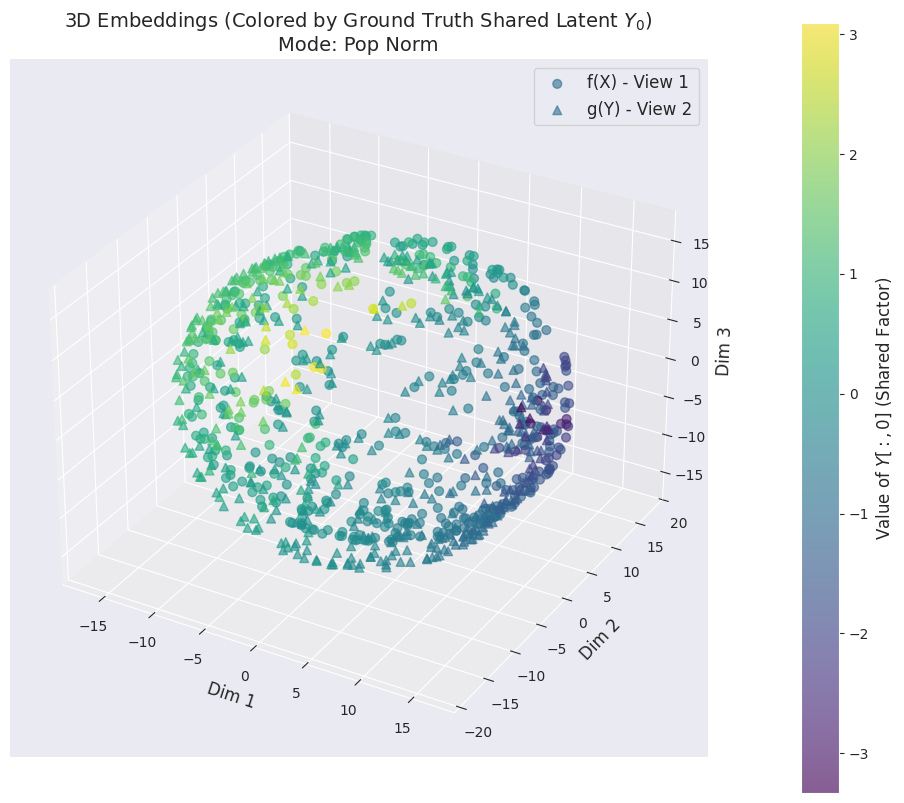

In [11]:

# --- 7. Embedding Visualization (3D) ---
# Visualizing f(X) and g(Y) in the shared space
print("\nGenerating 3D Visualization...")
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Subsample for clearer visualization (avoid clutter)
n_viz = 500
indices = np.random.choice(len(X_test), n_viz, replace=False)
fx_viz = fx[indices].cpu().numpy()
gy_viz = gy[indices].cpu().numpy()

# Color by the 1st shared component of Y (Ground Truth)
# If alignment is successful, points with similar colors should be close
c_viz = Y_test[indices, 0].cpu().numpy()

# Plot f(X) as Circles
p1 = ax.scatter(fx_viz[:, 0], fx_viz[:, 1], fx_viz[:, 2],
                c=c_viz, cmap='viridis', marker='o', alpha=0.6, s=40, label='f(X) - View 1')

# Plot g(Y) as Triangles
# Using the same colormap: if aligned, same colors should overlap
p2 = ax.scatter(gy_viz[:, 0], gy_viz[:, 1], gy_viz[:, 2],
                c=c_viz, cmap='viridis', marker='^', alpha=0.6, s=40, label='g(Y) - View 2')

# Draw lines between pairs to show alignment (Optional - can be messy if not aligned)
# for i in range(n_viz):
#     ax.plot([fx_viz[i,0], gy_viz[i,0]], [fx_viz[i,1], gy_viz[i,1]], [fx_viz[i,2], gy_viz[i,2]], color='gray', alpha=0.1)

ax.set_title(f"3D Embeddings (Colored by Ground Truth Shared Latent $Y_0$)\nMode: {'Cosine' if USE_COSINE_SIM else 'Pop Norm'}", fontsize=14)
ax.set_xlabel('Dim 1', fontsize=12)
ax.set_ylabel('Dim 2', fontsize=12)
ax.set_zlabel('Dim 3', fontsize=12)
ax.legend(fontsize=12)

# Add colorbar
cbar = plt.colorbar(p1, ax=ax, pad=0.1)
cbar.set_label('Value of $Y[:, 0]$ (Shared Factor)', fontsize=12)

plt.show()

## 1-2. Visualization of Learned 3D Representations
- Visualizes alignment and uniformity, demonstrating adaptation to the intrinsic dimension (concentration on a 2D spherical shell).

Starting training (Mode: Population Norm)...


100%|██████████| 600/600 [04:04<00:00,  2.46it/s]


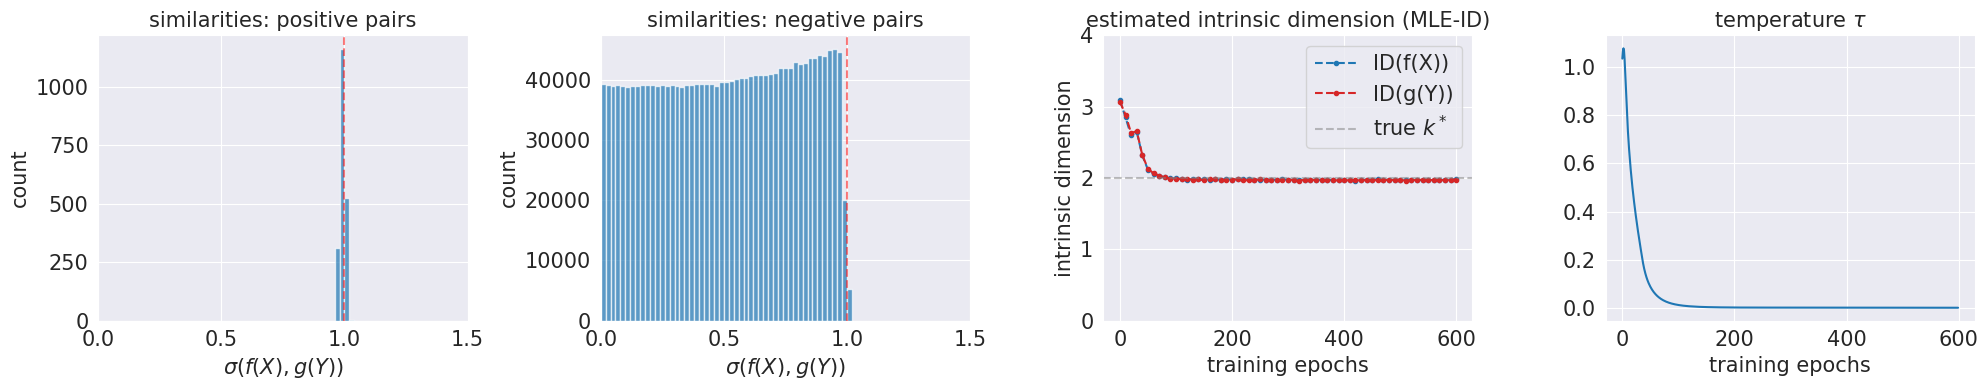


Generating Sequential 3D Visualization (Animation)...
Animation complete.


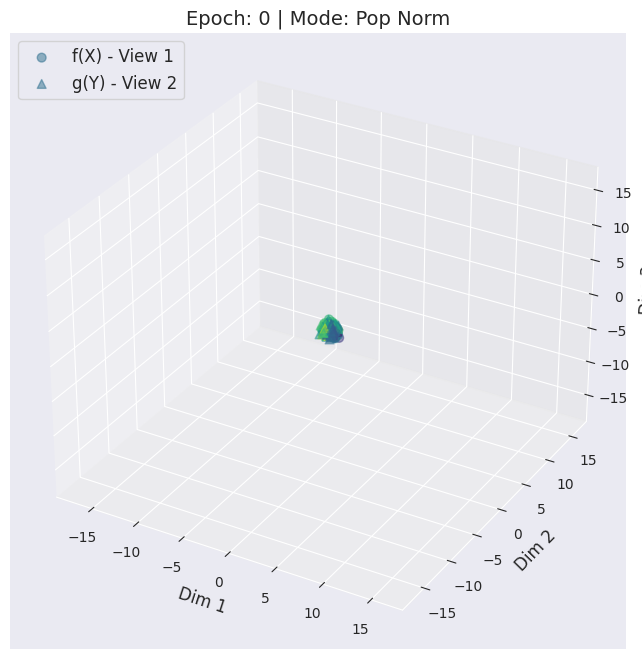

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation  # [Added] For sequential visualization
from tqdm import tqdm
import seaborn as sns

# Import skdim for Intrinsic Dimension estimation
try:
    from skdim.id import MLE
except ImportError:
    raise ImportError("Please install scikit-dimension: pip install scikit-dimension")

# --- 1. Configuration & Hyperparameters ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# True: 일반적인 Cosine Similarity 사용
# False: 논문의 Population-level Normalization 사용
USE_COSINE_SIM = False

# Dimensions
D1 = 20      # Input dim X
D2 = 20      # Input dim Y
K_STAR = 2   # Shared intrinsic dim (Target)
D_OUT = 3    # Output dimension (d > k*)

# Training Settings
N_TOTAL = 14000
N_TEST = 2000
N_NORM_EST = 2000 # Subset for norm estimation
N_TRAIN = N_TOTAL - N_TEST - N_NORM_EST

BATCH_SIZE = 256
EPOCHS = 600

# Learning Rates (Appendix G.3)
LR_NET = 1e-4
LR_TAU = 1e-3
WEIGHT_DECAY = 1e-4

# --- 2. Data Generation (Section 1.1) ---
def generate_synthetic_data(n_samples):
    # Yi ~ N(0, I_d2)
    Y = torch.randn(n_samples, D2)

    # Xi shares first k* components with Yi
    # The rest (d1 - k*) are independent noise
    xi_noise = torch.randn(n_samples, D1 - K_STAR)

    # Construct X: First k* cols are Y[:, :k*], rest are noise
    X_shared = Y[:, :K_STAR]
    X = torch.cat([X_shared, xi_noise], dim=1)

    return X.to(device), Y.to(device)

# --- 3. Model Architecture (Section 1.1) ---
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 논문의 5-layer 구조 유지하되, 학습 안정성을 위해 BatchNorm 추가
        self.net = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.BatchNorm1d(50),  # [추가] Norm stabilization

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),  # [추가]
            nn.ReLU(),

            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# --- 4. Initialization ---
X_all, Y_all = generate_synthetic_data(N_TOTAL)

# Split datasets
X_norm = X_all[:N_NORM_EST]
Y_norm = Y_all[:N_NORM_EST]
X_test = X_all[N_NORM_EST : N_NORM_EST + N_TEST]
Y_test = Y_all[N_NORM_EST : N_NORM_EST + N_TEST]
X_train = X_all[N_NORM_EST + N_TEST:]
Y_train = Y_all[N_NORM_EST + N_TEST:]

f_model = Encoder(D1, D_OUT).to(device)
g_model = Encoder(D2, D_OUT).to(device)
log_tau = nn.Parameter(torch.tensor(0.0)) # exp(0) = 1.0

optimizer = optim.AdamW([
    {'params': f_model.parameters(), 'lr': LR_NET},
    {'params': g_model.parameters(), 'lr': LR_NET},
    {'params': [log_tau], 'lr': LR_TAU}
], weight_decay=WEIGHT_DECAY)

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Metrics Storage
history = {
    'tau': [],
    'id_f': [], 'id_g': [],
    'norm_cv_f': [], 'norm_cv_g': [],
    'max_sim': [],
    'epochs': []
}
embedding_logs = []  # [Added] To store embeddings sequentially

# --- 5. Training Loop with Diagnostics ---
print(f"Starting training (Mode: {'Cosine Similarity' if USE_COSINE_SIM else 'Population Norm'})...")

for epoch in tqdm(range(EPOCHS)):
    f_model.train()
    g_model.train()

    # [논문 방식] Expected Norm 추정 (Appendix G.1)
    with torch.no_grad():
        if not USE_COSINE_SIM:
            f_norm_set = f_model(X_norm)
            g_norm_set = g_model(Y_norm)
            E_norm_f = torch.mean(torch.norm(f_norm_set, dim=1))
            E_norm_g = torch.mean(torch.norm(g_norm_set, dim=1))
        else:
            E_norm_f = E_norm_g = 1.0 # Dummy

    batch_cv_f = []
    batch_max_sim = []

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        tau = torch.exp(log_tau)

        fx = f_model(x_batch)
        gy = g_model(y_batch)

        # --- [진단 1] Norm Concentration Check ---
        norms_f = torch.norm(fx, dim=1)
        cv_f = torch.std(norms_f) / (torch.mean(norms_f) + 1e-8)
        batch_cv_f.append(cv_f.item())

        # --- Similarity Calculation ---
        if USE_COSINE_SIM:
            fx_n = F.normalize(fx, p=2, dim=1)
            gy_n = F.normalize(gy, p=2, dim=1)
            similarity_matrix = fx_n @ gy_n.T
        else:
            similarity_matrix = (fx @ gy.T) / (E_norm_f * E_norm_g)

        # --- [진단 3] Similarity Scale Check ---
        batch_max_sim.append(similarity_matrix.max().item())

        logits = similarity_matrix / tau
        labels = torch.arange(len(x_batch)).to(device)

        loss = (nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.T, labels)) / 2

        loss.backward()
        optimizer.step()

    # Record Per Epoch
    history['tau'].append(tau.item())
    history['norm_cv_f'].append(np.mean(batch_cv_f))
    history['max_sim'].append(np.max(batch_max_sim))

    # Record ID and Embeddings periodically
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        f_model.eval()
        g_model.eval()
        with torch.no_grad():
            # 1. MLE Estimation
            est = MLE(K=20)
            id_f = est.fit(f_model(X_test).cpu().numpy()).dimension_
            id_g = est.fit(g_model(Y_test).cpu().numpy()).dimension_

            history['id_f'].append(id_f)
            history['id_g'].append(id_g)
            history['epochs'].append(epoch)

            # 2. Log Embeddings for Animation [Added]
            # Save CPU copies to save VRAM and allows visualization later
            curr_fx = f_model(X_test).cpu().numpy()
            curr_gy = g_model(Y_test).cpu().numpy()
            embedding_logs.append({
                'epoch': epoch,
                'fx': curr_fx,
                'gy': curr_gy
            })

# --- 6. Diagnostic Plotting ---
f_model.eval()
g_model.eval()
with torch.no_grad():
    fx = f_model(X_test)
    gy = g_model(Y_test)
    if USE_COSINE_SIM:
        sim_mat = F.normalize(fx, dim=1) @ F.normalize(gy, dim=1).T
    else:
        E_f = torch.mean(torch.norm(f_model(X_norm), dim=1))
        E_g = torch.mean(torch.norm(g_model(Y_norm), dim=1))
        sim_mat = (fx @ gy.T) / (E_f * E_g)

    pos_sims = torch.diag(sim_mat).cpu().numpy()
    mask = ~torch.eye(N_TEST, dtype=bool).to(device)
    neg_sims = torch.masked_select(sim_mat, mask).cpu().numpy()

sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
SIZE = 15
TICK_SIZE = 15
FIXED_RANGE = (0.0, 1.5)
BIN_WIDTH = 0.02
FIXED_BINS = np.arange(FIXED_RANGE[0], FIXED_RANGE[1] + BIN_WIDTH, BIN_WIDTH)

# (1) Positive pairs
axes[0].hist(pos_sims, bins=FIXED_BINS, color='tab:blue', alpha=0.7)
axes[0].set_title("similarities: positive pairs", fontsize=SIZE)
axes[0].set_xlabel(r"$\sigma(f(X), g(Y))$", fontsize=SIZE)
axes[0].set_ylabel("count", fontsize=SIZE)
axes[0].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[0].axvline(1.0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlim(FIXED_RANGE)

# (2) Negative pairs
axes[1].hist(neg_sims, bins=FIXED_BINS, color='tab:blue', alpha=0.7)
axes[1].set_title("similarities: negative pairs", fontsize=SIZE)
axes[1].set_xlabel(r"$\sigma(f(X), g(Y))$", fontsize=SIZE)
axes[1].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[1].set_ylabel("count", fontsize=SIZE)
axes[1].axvline(1.0, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlim(FIXED_RANGE)

# (3) Intrinsic dimension
axes[2].plot(history['epochs'], history['id_f'], "o--", label="ID(f(X))", markersize=3)
axes[2].plot(history['epochs'], history['id_g'], "o--", label="ID(g(Y))", markersize=3, color='tab:red')
axes[2].axhline(K_STAR, linestyle="--", alpha=0.5, label=r"true $k^*$", color='tab:gray')
axes[2].set_title("estimated intrinsic dimension (MLE-ID)", fontsize=SIZE)
axes[2].set_xlabel("training epochs", fontsize=SIZE)
axes[2].tick_params(axis='both', which='major', labelsize=TICK_SIZE)
axes[2].set_ylabel("intrinsic dimension", fontsize=SIZE)
axes[2].set_ylim(0, max(4, K_STAR + 1))
axes[2].legend(fontsize=TICK_SIZE)

# (4) Temperature
axes[3].plot(range(len(history['tau'])), history['tau'], color='tab:blue')
axes[3].set_title(r"temperature $\tau$", fontsize=SIZE)
axes[3].set_xlabel("training epochs", fontsize=SIZE)
axes[3].tick_params(axis='both', which='major', labelsize=TICK_SIZE)

plt.tight_layout()
plt.show()

# --- 7. Sequential 3D Visualization (Animation) ---
print("\nGenerating Sequential 3D Visualization (Animation)...")

# Setup Indices for Visualization (Tracking same points)
n_viz = 500
viz_indices = np.random.choice(len(X_test), n_viz, replace=False)
c_viz = Y_test[viz_indices, 0].cpu().numpy() # Color by Ground Truth

# Calculate Global Bounds for fixed camera
all_fx = np.concatenate([d['fx'][viz_indices] for d in embedding_logs])
all_gy = np.concatenate([d['gy'][viz_indices] for d in embedding_logs])
all_pts = np.concatenate([all_fx, all_gy])
min_val = np.min(all_pts) - 0.5
max_val = np.max(all_pts) + 0.5

fig_anim = plt.figure(figsize=(10, 8))
ax_anim = fig_anim.add_subplot(111, projection='3d')

def update_graph(frame_idx):
    ax_anim.clear()
    data = embedding_logs[frame_idx]
    epoch = data['epoch']

    # Extract data for this frame
    fx_curr = data['fx'][viz_indices]
    gy_curr = data['gy'][viz_indices]

    # Titles and Labels
    ax_anim.set_title(f"Epoch: {epoch} | Mode: {'Cosine' if USE_COSINE_SIM else 'Pop Norm'}", fontsize=14)
    ax_anim.set_xlabel('Dim 1', fontsize=12)
    ax_anim.set_ylabel('Dim 2', fontsize=12)
    ax_anim.set_zlabel('Dim 3', fontsize=12)

    # Fix axes to global min/max so we see the points moving, not the axes scaling
    ax_anim.set_xlim(min_val, max_val)
    ax_anim.set_ylim(min_val, max_val)
    ax_anim.set_zlim(min_val, max_val)

    # Scatter Plots
    p1 = ax_anim.scatter(fx_curr[:, 0], fx_curr[:, 1], fx_curr[:, 2],
                         c=c_viz, cmap='viridis', marker='o', alpha=0.5, s=40, label='f(X) - View 1')
    p2 = ax_anim.scatter(gy_curr[:, 0], gy_curr[:, 1], gy_curr[:, 2],
                         c=c_viz, cmap='viridis', marker='^', alpha=0.5, s=40, label='g(Y) - View 2')
    ax_anim.legend(loc='upper left', fontsize=12)

    # Note: Adding colorbar inside loop can be buggy, usually added once outside or static.
    # Here we just use colors for qualitative grouping.

# Create Animation
ani = animation.FuncAnimation(fig_anim, update_graph, frames=len(embedding_logs), interval=1000, repeat=True)

ani.save('animation.mp4',fps=5)
print("Animation complete.")

## 1-3. Additional adaptation experimental results: norm concentration (Appendix G)
- Refer to Figure 6,7 in Gui et al., 2025

--- Reproducing NeurIPS Paper Figures 6 & 7 (Device: cuda) ---
Starting training for 600 epochs...


100%|██████████| 600/600 [01:55<00:00,  5.19it/s]


Training Complete.
Saved: figure_7_evolution.mp4


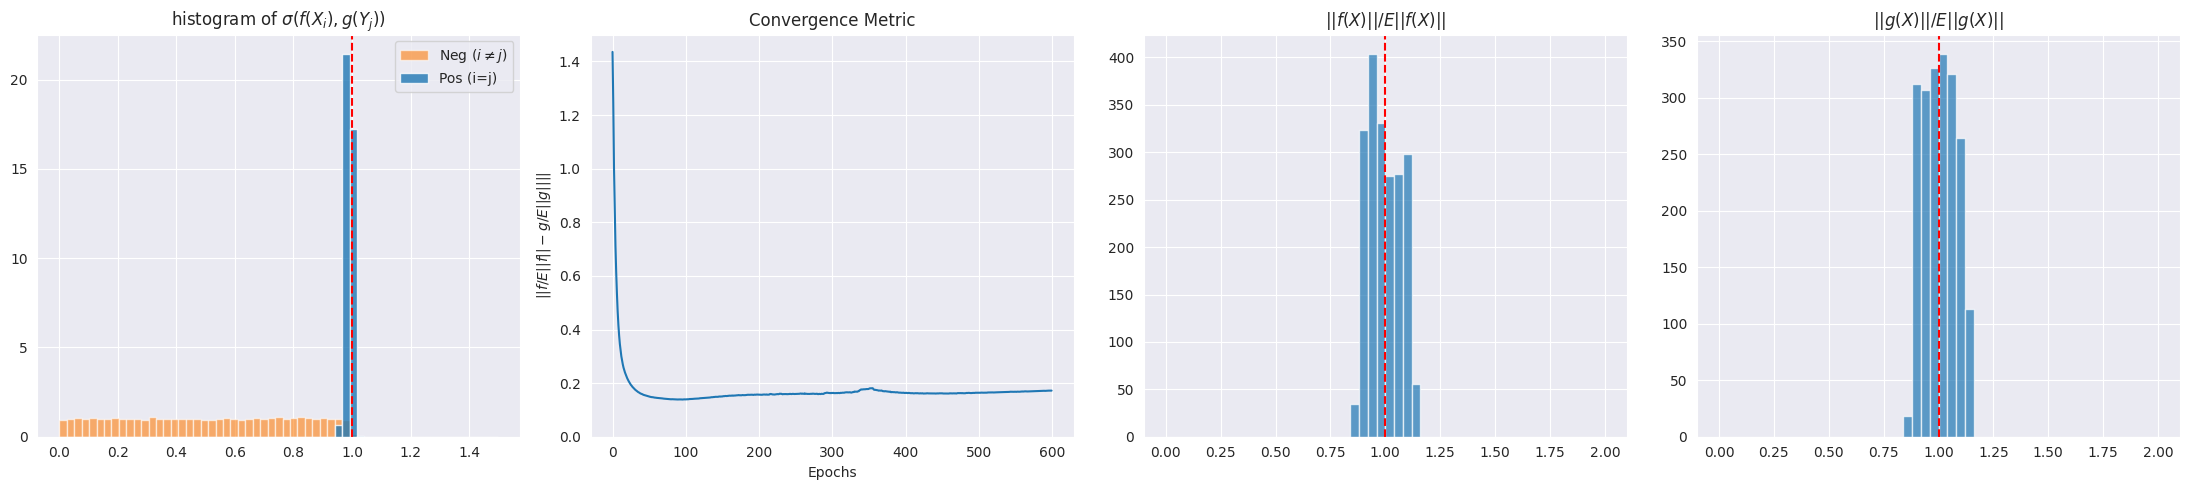

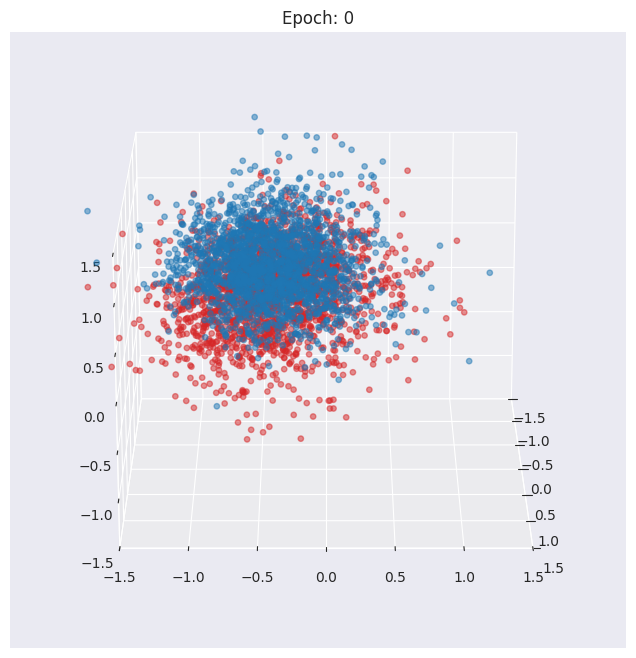

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import seaborn as sns
import os

# --- 1. Configuration & Hyperparameters ---
SEED = 2025
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paper Experiment Settings
USE_COSINE_SIM = False

# Bias/BN Settings
# [Updated] Enable BN to fix training instability (Dead ReLU)
USE_BATCHNORM = True

# Dimensions
D1 = 20      # Input dim X
D2 = 20      # Input dim Y
K_STAR = 2   # Shared intrinsic dim (Target)
D_OUT = 3    # Output dimension (d=3 for visualization)

# Training Settings
N_TOTAL = 14000
N_TEST = 2000
N_NORM_EST = 2000
N_TRAIN = N_TOTAL - N_TEST - N_NORM_EST

BATCH_SIZE = 512
EPOCHS = 600
ANIMATION_INTERVAL = 10

# Learning Rates
LR_NET = 1e-4
LR_TAU = 1e-3
WEIGHT_DECAY = 1e-4

# --- 2. Data Generation ---
def generate_synthetic_data(n_samples):
    Y = torch.randn(n_samples, D2)
    xi_noise = torch.randn(n_samples, D1 - K_STAR)
    X_shared = Y[:, :K_STAR]
    X = torch.cat([X_shared, xi_noise], dim=1)
    return X.to(device), Y.to(device)

# --- 3. Model Architecture ---
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        layers = []

        # Layer 1
        layers.append(nn.Linear(input_dim, 50, bias=False))
        if USE_BATCHNORM:
            # affine=False: Forces mean=0, std=1 without learning new bias/scale.
            layers.append(nn.BatchNorm1d(50, affine=False))
        layers.append(nn.ReLU())

        # Layer 2
        layers.append(nn.Linear(50, 50, bias=False))
        if USE_BATCHNORM:
            layers.append(nn.BatchNorm1d(50, affine=False))
        layers.append(nn.ReLU())

        # Layer 3
        layers.append(nn.Linear(50, 50, bias=False))
        if USE_BATCHNORM:
            layers.append(nn.BatchNorm1d(50, affine=False))
        layers.append(nn.ReLU())

        # Layer 4
        layers.append(nn.Linear(50, 50, bias=False))
        if USE_BATCHNORM:
            layers.append(nn.BatchNorm1d(50, affine=False))
        layers.append(nn.ReLU())

        # Output Layer (No ReLU for embedding head)
        layers.append(nn.Linear(50, output_dim, bias=False))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- 4. Animation Helper ---
def update_graph(num, data_store, scatters, title_text, ax):
    frame_data = data_store[num]
    f_data = frame_data['f']
    g_data = frame_data['g']
    epoch_val = frame_data['epoch']

    # Update scatter plots
    scatters[0]._offsets3d = (f_data[:,0], f_data[:,1], f_data[:,2])
    scatters[1]._offsets3d = (g_data[:,0], g_data[:,1], g_data[:,2])

    title_text.set_text(f'Epoch: {epoch_val}')
    ax.view_init(elev=20, azim=num * 0.8)
    return scatters

# --- 5. Main Execution Block ---
if __name__ == "__main__":
    print(f"--- Reproducing NeurIPS Paper Figures 6 & 7 (Device: {device}) ---")

    # A. Data Prep
    X_all, Y_all = generate_synthetic_data(N_TOTAL)

    X_norm = X_all[:N_NORM_EST]
    Y_norm = Y_all[:N_NORM_EST]
    X_test = X_all[N_NORM_EST : N_NORM_EST + N_TEST]
    Y_test = Y_all[N_NORM_EST : N_NORM_EST + N_TEST]
    X_train = X_all[N_NORM_EST + N_TEST:]
    Y_train = Y_all[N_NORM_EST + N_TEST:]

    # B. Model Setup
    f_model = Encoder(D1, D_OUT).to(device)
    g_model = Encoder(D2, D_OUT).to(device)
    log_tau = nn.Parameter(torch.tensor(0.0))

    optimizer = optim.AdamW([
        {'params': f_model.parameters(), 'lr': LR_NET},
        {'params': g_model.parameters(), 'lr': LR_NET},
        {'params': [log_tau], 'lr': LR_TAU}
    ], weight_decay=WEIGHT_DECAY)

    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # C. Storage
    history = {
        'convergence_metric': [], # Original (Stale E_norm)
        'corrected_metric': [],   # [NEW] Batch-Corrected (Real-time E_norm)
        'epochs': [],
        'tau': [],
    }
    animation_frames = []

    print(f"Starting training for {EPOCHS} epochs...")

    for epoch in tqdm(range(EPOCHS)):
        f_model.train()
        g_model.train()

        epoch_diffs = []
        epoch_corrected_diffs = []

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            tau = torch.exp(log_tau)

            # 1. Estimate Population Norms (on Subset) - Fixed/Stale
            with torch.no_grad():
                if not USE_COSINE_SIM:
                    f_norm_set = f_model(X_norm)
                    g_norm_set = g_model(Y_norm)
                    E_norm_f = torch.mean(torch.norm(f_norm_set, dim=1))
                    E_norm_g = torch.mean(torch.norm(g_norm_set, dim=1))
                else:
                    E_norm_f = E_norm_g = 1.0

            fx = f_model(x_batch)
            gy = g_model(y_batch)

            # 2. Calc Similarity Matrix
            if not USE_COSINE_SIM:
                similarity_matrix = (fx @ gy.T) / (E_norm_f * E_norm_g)
            else:
                fx_n = F.normalize(fx, p=2, dim=1)
                gy_n = F.normalize(gy, p=2, dim=1)
                similarity_matrix = fx_n @ gy_n.T

            logits = similarity_matrix / tau
            labels = torch.arange(len(x_batch)).to(device)

            loss_i = nn.CrossEntropyLoss()(logits, labels)
            loss_t = nn.CrossEntropyLoss()(logits.T, labels)
            loss = (loss_i + loss_t) / 2

            loss.backward()
            optimizer.step()

            # 3. Track Metrics
            with torch.no_grad():
                if not USE_COSINE_SIM:
                    # Metric A: Original (Paper)
                    # Captures global scaling lag
                    fx_pop = fx / E_norm_f
                    gy_pop = gy / E_norm_g
                    diff = torch.mean(torch.norm(fx_pop - gy_pop, dim=1))

                    # Metric B: Batch-Corrected
                    batch_norm_f = torch.mean(torch.norm(fx, dim=1))
                    batch_norm_g = torch.mean(torch.norm(gy, dim=1))
                    fx_batch = fx / batch_norm_f
                    gy_batch = gy / batch_norm_g
                    diff_corrected = torch.mean(torch.norm(fx_batch - gy_batch, dim=1))
                else:
                    diff = torch.tensor(0.0)
                    diff_corrected = torch.tensor(0.0)

                epoch_diffs.append(diff.item())
                epoch_corrected_diffs.append(diff_corrected.item())

        history['convergence_metric'].append(np.mean(epoch_diffs))
        history['corrected_metric'].append(np.mean(epoch_corrected_diffs))
        history['epochs'].append(epoch)
        history['tau'].append(torch.exp(log_tau).item())

        # Save Frame for Animation (Figure 7)
        if epoch % ANIMATION_INTERVAL == 0 or epoch == EPOCHS - 1:
            f_model.eval()
            g_model.eval()
            with torch.no_grad():
                fx_test = f_model(X_test).cpu().numpy()
                gy_test = g_model(Y_test).cpu().numpy()

                if not USE_COSINE_SIM:
                     # For visual clarity, we use the batch mean norm fix
                     norm_f = np.mean(np.linalg.norm(fx_test, axis=1))
                     norm_g = np.mean(np.linalg.norm(gy_test, axis=1))
                else:
                     norm_f = 1.0
                     norm_g = 1.0

                animation_frames.append({
                    'epoch': epoch,
                    'f': fx_test / norm_f,
                    'g': gy_test / norm_g
                })

    print("Training Complete.")

    # --- Plotting ---
    f_model.eval()
    g_model.eval()
    with torch.no_grad():
        fx = f_model(X_test)
        gy = g_model(Y_test)
        f_norm_final = f_model(X_norm)
        g_norm_final = g_model(Y_norm)
        E_f = torch.mean(torch.norm(f_norm_final, dim=1))
        E_g = torch.mean(torch.norm(g_norm_final, dim=1))
        sim_mat = (fx @ gy.T) / (E_f * E_g)
        pos_sims = torch.diag(sim_mat).cpu().numpy()
        mask = ~torch.eye(N_TEST, dtype=bool).to(device)
        neg_sims = torch.masked_select(sim_mat, mask).cpu().numpy()
        np.random.shuffle(neg_sims)
        neg_sims = neg_sims[:50000]

        # Norm ratios
        norm_ratios_f = (torch.norm(fx, dim=1) / E_f).cpu().numpy()
        norm_ratios_g = (torch.norm(gy, dim=1) / E_g).cpu().numpy()

        # [Fix 1] Handle NaN/Inf
        norm_ratios_f = np.nan_to_num(norm_ratios_f, nan=1.0, posinf=1.0, neginf=1.0)
        norm_ratios_g = np.nan_to_num(norm_ratios_g, nan=1.0, posinf=1.0, neginf=1.0)

    sns.set_style("darkgrid")
    fig6, axes = plt.subplots(1, 4, figsize=(22, 5))
    bins_sim = np.linspace(0, 1.5, 60)
    axes[0].hist(neg_sims, bins=bins_sim, color='tab:orange', alpha=0.6, label=r'Neg ($i \ne j$)', density=True)
    axes[0].hist(pos_sims, bins=bins_sim, color='tab:blue', alpha=0.8, label='Pos (i=j)', density=True)
    axes[0].axvline(1.0, color='r', linestyle='--')
    axes[0].legend()
    axes[0].set_title(r"histogram of $\sigma(f(X_i), g(Y_j))$")


    axes[1].plot(history['epochs'], history['corrected_metric'], label=r"ave. of $||f/E||f|| - g/E||g||||$", color='tab:blue')
    axes[1].set_title(r"Convergence Metric")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel(r"$||f/E||f|| - g/E||g||||$")
    axes[1].set_ylim(bottom=0)

    # [Fix 2] Use range=(0, 3) to force visibility even with outliers
    axes[2].hist(norm_ratios_f, range = (0,2), bins=50, color='tab:blue', alpha=0.7)
    axes[2].axvline(1.0, color='r', linestyle='--')
    axes[2].set_title(r"$||f(X)|| / E||f(X)||$")
    #axes[2].set_xlim(0, 2) # Range handles it better

    axes[3].hist(norm_ratios_g, range = (0,2), bins=50, color='tab:blue', alpha=0.7)
    axes[3].axvline(1.0, color='r', linestyle='--')
    axes[3].set_title(r"$||g(X)|| / E||g(X)||$")
    #axes[3].set_xlim(0, 2)

    plt.tight_layout()
    plt.savefig('figure_6_reproduction.png')

    # --- Animation ---
    fig_anim = plt.figure(figsize=(10, 8))
    ax_anim = fig_anim.add_subplot(111, projection='3d')
    scat_f = ax_anim.scatter([], [], [], c='tab:red', s=15, alpha=0.5, label='f(X)')
    scat_g = ax_anim.scatter([], [], [], c='tab:blue', s=15, alpha=0.5, label='g(Y)')
    max_range = 1.5
    ax_anim.set_xlim(-max_range, max_range)
    ax_anim.set_ylim(-max_range, max_range)
    ax_anim.set_zlim(-max_range, max_range)
    title_text = ax_anim.set_title("Epoch: 0")
    anim = animation.FuncAnimation(fig_anim, update_graph, frames=len(animation_frames),
                                   fargs=(animation_frames, [scat_f, scat_g], title_text, ax_anim),
                                   interval=100, blit=False)
    try:
        anim.save('figure_7_evolution.mp4', writer='ffmpeg', fps=10, dpi=120)
        print("Saved: figure_7_evolution.mp4")
    except:
        anim.save('figure_7_evolution.gif', writer='pillow', fps=10)
        print("Saved: figure_7_evolution.gif")

## 1-4. Additional adaptation experimental results: alignment versus simply similarity maximization (Appendix G)
- Refer to Figure 8,9 in Gui et al., 2025


>>> STARTING FIGURE 8 REPRODUCTION <<<

=== Running Figure 8 (d=20, k*=5, layers=5) ===
Config: D=20, K*=5, Layers=5


100%|██████████| 600/600 [01:50<00:00,  5.43it/s]


Saved figure_8_reproduction.png

>>> STARTING FIGURE 9 REPRODUCTION <<<

=== Running Figure 9 (d=3, k*=2, layers=2) ===
Config: D=3, K*=2, Layers=2


100%|██████████| 600/600 [01:22<00:00,  7.31it/s]


Saved figure_9_reproduction.png
Generating Figure 9 Animation...
Saved figure_9_evolution.mp4

All experiments completed.


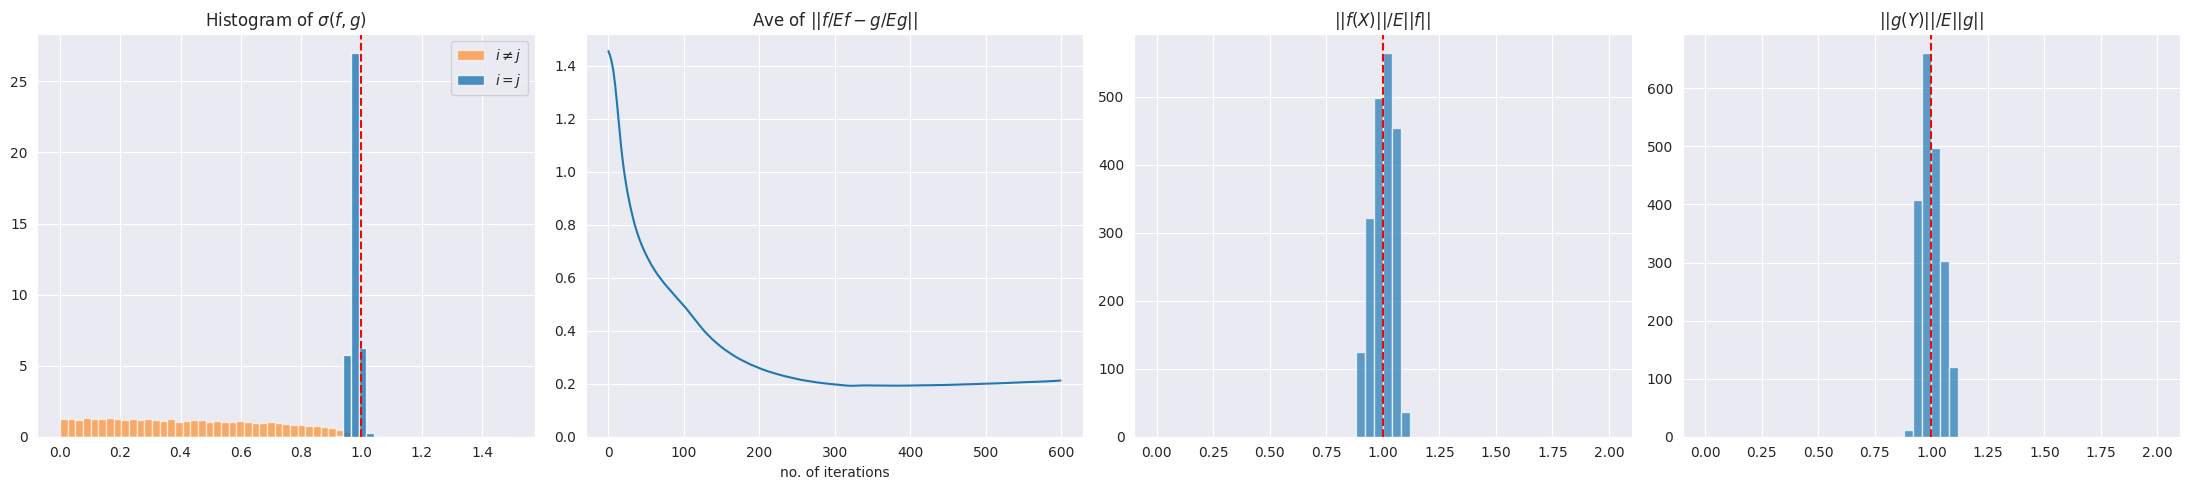

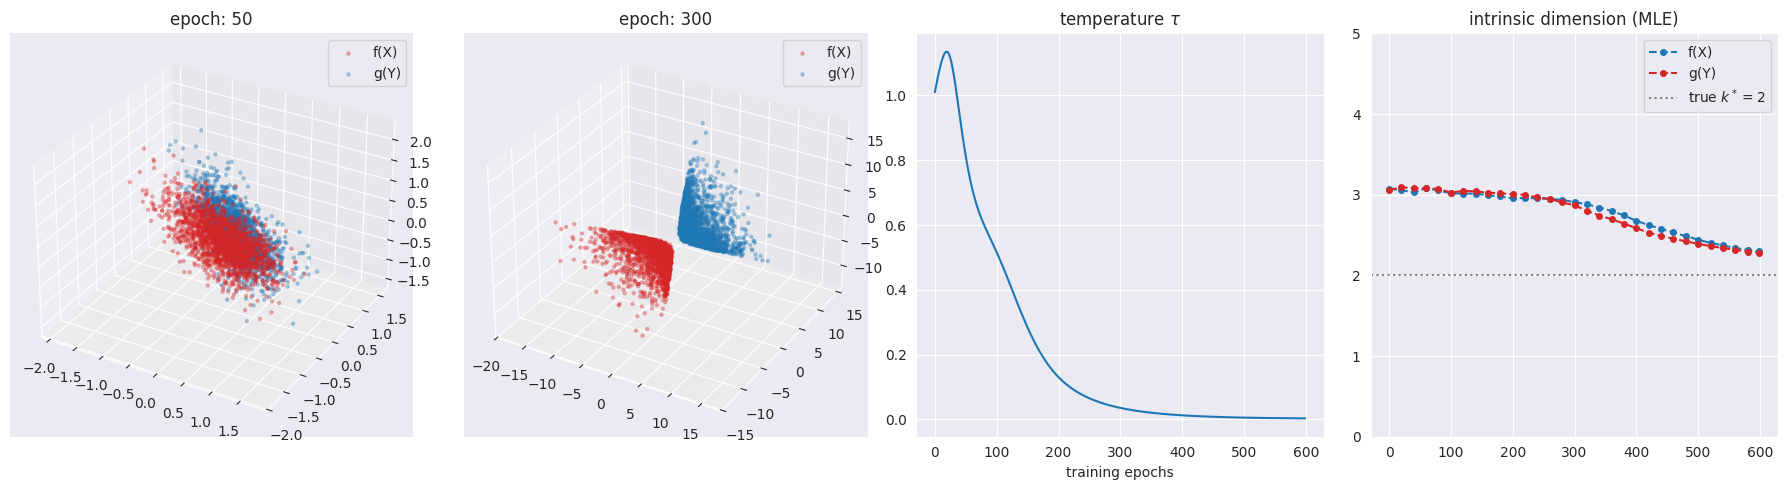

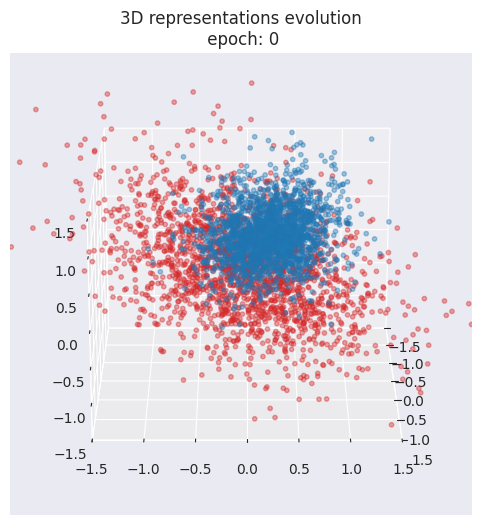

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import seaborn as sns
import os

# --- Common Configuration ---
SEED = 2025
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

USE_COSINE_SIM = False
USE_BATCHNORM = True # Robust centering

# Training Settings
N_TOTAL = 14000
N_TEST = 2000
N_NORM_EST = 2000
N_TRAIN = N_TOTAL - N_TEST - N_NORM_EST
BATCH_SIZE = 1024
EPOCHS = 600

# Learning Rates
LR_NET = 1e-4
LR_TAU = 1e-3
WEIGHT_DECAY = 1e-4

# --- Helper: Intrinsic Dimension Estimation (MLE) ---
def estimate_intrinsic_dimension(data, k=20):
    """
    Levina-Bickel Maximum Likelihood Estimator for Intrinsic Dimension.
    data: (N, D) tensor or numpy array
    k: number of nearest neighbors
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).to(device)

    n = data.shape[0]
    # Compute pairwise distance matrix (L2)
    # Using specific formula to save memory: ||a-b||^2 = ||a||^2 + ||b||^2 - 2<a,b>
    # Note: For accurate NN, double precision is preferred, but float32 usually okay for demo
    dist_mat = torch.cdist(data, data, p=2)

    # Get top k+1 (including self) smallest distances
    # values: (N, k+1)
    topk_vals, _ = torch.topk(dist_mat, k=k+1, largest=False, dim=1)

    # Exclude self (index 0, dist 0)
    # r_k(x) is the distance to the k-th neighbor (last col)
    # r_j(x) are distances to j=1..k neighbors

    knn_dists = topk_vals[:, 1:] # (N, k)

    # Formula: ID_i = [ 1/(k-1) * sum_{j=1}^{k-1} log(T_k / T_j) ] ^ -1
    # Note: different implementations use k or k-1. We follow standard Levina-Bickel.
    # T_k is radius (k-th neighbor distance)

    T_k = knn_dists[:, -1].unsqueeze(1) # Max radius for each point
    T_j = knn_dists[:, :-1] # All neighbors up to k-1

    # Avoid log(0) or div by 0
    T_k = torch.clamp(T_k, min=1e-8)
    T_j = torch.clamp(T_j, min=1e-8)

    sum_log = torch.sum(torch.log(T_k / T_j), dim=1)
    mle_ids = (k - 2) / sum_log # Correction for small k often uses k-2 or k-1

    return torch.mean(mle_ids).item()

# --- 2. Data Generation ---
def generate_synthetic_data(n_samples, d1, d2, k_star):
    Y = torch.randn(n_samples, d2)
    # If d1 > k_star, add noise. If d1 == k_star, X is subspace of Y.
    if d1 > k_star:
        xi_noise = torch.randn(n_samples, d1 - k_star)
        X_shared = Y[:, :k_star]
        X = torch.cat([X_shared, xi_noise], dim=1)
    else:
        X = Y[:, :d1] # Fallback if d1 <= k_star (not used in these expts)

    return X.to(device), Y.to(device)

# --- 3. Model Architecture (Dynamic Depth) ---
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=5):
        super().__init__()
        layers = []

        # Hidden layers
        curr_dim = input_dim
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(curr_dim, 50, bias=False))
            if USE_BATCHNORM:
                layers.append(nn.BatchNorm1d(50, affine=False))
            layers.append(nn.ReLU())
            curr_dim = 50

        # Output layer
        layers.append(nn.Linear(curr_dim, output_dim, bias=False))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- 4. Experiment Runner ---
def run_experiment(exp_name, d1, d2, k_star, d_out, num_layers, make_animation=False):
    print(f"\n=== Running {exp_name} ===")
    print(f"Config: D={d_out}, K*={k_star}, Layers={num_layers}")

    # 1. Data
    X_all, Y_all = generate_synthetic_data(N_TOTAL, d1, d2, k_star)
    X_norm = X_all[:N_NORM_EST]
    Y_norm = Y_all[:N_NORM_EST]
    X_test = X_all[N_NORM_EST : N_NORM_EST + N_TEST]
    Y_test = Y_all[N_NORM_EST : N_NORM_EST + N_TEST]
    X_train = X_all[N_NORM_EST + N_TEST:]
    Y_train = Y_all[N_NORM_EST + N_TEST:]

    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 2. Model
    f_model = Encoder(d1, d_out, num_layers).to(device)
    g_model = Encoder(d2, d_out, num_layers).to(device)
    log_tau = nn.Parameter(torch.tensor(0.0))

    optimizer = optim.AdamW([
        {'params': f_model.parameters(), 'lr': LR_NET},
        {'params': g_model.parameters(), 'lr': LR_NET},
        {'params': [log_tau], 'lr': LR_TAU}
    ], weight_decay=WEIGHT_DECAY)

    # 3. Training Loop
    history = {
        'epochs': [],
        'tau': [],
        'convergence_metric': [], # For Fig 8
        'id_f': [], 'id_g': [],   # For Fig 9
        'embeddings_epoch_50': None,
        'embeddings_epoch_300': None
    }

    anim_frames = []

    for epoch in tqdm(range(EPOCHS)):
        f_model.train()
        g_model.train()

        epoch_diffs = []

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            tau = torch.exp(log_tau)

            with torch.no_grad():
                if not USE_COSINE_SIM:
                    f_set = f_model(X_norm)
                    g_set = g_model(Y_norm)
                    E_f = torch.mean(torch.norm(f_set, dim=1))
                    E_g = torch.mean(torch.norm(g_set, dim=1))
                else:
                    E_f = E_g = 1.0

            fx = f_model(x_batch)
            gy = g_model(y_batch)

            if not USE_COSINE_SIM:
                similarity_matrix = (fx @ gy.T) / (E_f * E_g)
            else:
                similarity_matrix = F.normalize(fx, p=2, dim=1) @ F.normalize(gy, p=2, dim=1).T

            logits = similarity_matrix / tau
            labels = torch.arange(len(x_batch)).to(device)
            loss = (nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.T, labels)) / 2

            loss.backward()
            optimizer.step()

            # Track Norm Diff (for Fig 8)
            with torch.no_grad():
                if not USE_COSINE_SIM:
                    d_val = torch.mean(torch.norm(fx/E_f - gy/E_g, dim=1))
                    epoch_diffs.append(d_val.item())

        # End of Epoch Stats
        history['epochs'].append(epoch)
        history['tau'].append(torch.exp(log_tau).item())
        history['convergence_metric'].append(np.mean(epoch_diffs) if epoch_diffs else 0.0)

        # Periodic Checks (MLE ID & Snapshots)
        if epoch % 10 == 0 or epoch == EPOCHS - 1:
            f_model.eval()
            g_model.eval()
            with torch.no_grad():
                fx_t = f_model(X_test).cpu()
                gy_t = g_model(Y_test).cpu()

                # Estimate ID (CPU)
                id_f = estimate_intrinsic_dimension(fx_t, k=20)
                id_g = estimate_intrinsic_dimension(gy_t, k=20)
                history['id_f'].append(id_f)
                history['id_g'].append(id_g)

                # Snapshots for scatter plot
                if epoch == 50:
                    history['embeddings_epoch_50'] = (fx_t.numpy(), gy_t.numpy())
                if epoch == 300:
                    history['embeddings_epoch_300'] = (fx_t.numpy(), gy_t.numpy())

                # Animation frames (only if requested)
                if make_animation and (epoch % 10 == 0):
                    # Normalize for visualization
                    nm_f = torch.mean(torch.norm(fx_t, dim=1)).item()
                    nm_g = torch.mean(torch.norm(gy_t, dim=1)).item()
                    anim_frames.append({
                        'epoch': epoch,
                        'f': fx_t.numpy() / nm_f,
                        'g': gy_t.numpy() / nm_g
                    })

    return f_model, g_model, history, anim_frames, (X_norm, Y_norm, X_test, Y_test)

# --- 5. Plotting Functions ---

def plot_figure_8(history, f_model, g_model, data_tuple):
    """Reproduces Figure 8 (Histograms & Convergence)"""
    X_norm, Y_norm, X_test, Y_test = data_tuple

    f_model.eval()
    g_model.eval()
    with torch.no_grad():
        # Recalculate E_norm
        E_f = torch.mean(torch.norm(f_model(X_norm), dim=1))
        E_g = torch.mean(torch.norm(g_model(Y_norm), dim=1))

        fx = f_model(X_test)
        gy = g_model(Y_test)

        # Sim Matrix
        sim_mat = (fx @ gy.T) / (E_f * E_g)
        pos_sims = torch.diag(sim_mat).cpu().numpy()
        mask = ~torch.eye(len(X_test), dtype=bool).to(device)
        neg_sims = torch.masked_select(sim_mat, mask).cpu().numpy()
        np.random.shuffle(neg_sims)
        neg_sims = neg_sims[:50000]

        norm_r_f = (torch.norm(fx, dim=1) / E_f).cpu().numpy()
        norm_r_g = (torch.norm(gy, dim=1) / E_g).cpu().numpy()

    sns.set_style("darkgrid")
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))

    # 1. Similarity Hist
    bins = np.linspace(0, 1.5, 60)
    axes[0].hist(neg_sims, bins=bins, color='tab:orange', alpha=0.6, label=r'$i \ne j$', density=True)
    axes[0].hist(pos_sims, bins=bins, color='tab:blue', alpha=0.8, label=r'$i = j$', density=True)
    axes[0].axvline(1.0, color='r', linestyle='--')
    axes[0].set_title(r"Histogram of $\sigma(f, g)$")
    axes[0].legend()

    # 2. Convergence
    axes[1].plot(history['epochs'], history['convergence_metric'])
    axes[1].set_title(r"Ave of $|| f/Ef - g/Eg ||$")
    axes[1].set_xlabel("no. of iterations")
    axes[1].set_ylim(bottom=0)

    # 3. Norm f
    axes[2].hist(norm_r_f, range = (0,2), bins=50, color='tab:blue', alpha=0.7)
    axes[2].axvline(1.0, color='r', linestyle='--')
    axes[2].set_title(r"$||f(X)|| / E||f||$")
    #axes[2].set_xlim(0, 2)

    # 4. Norm g
    axes[3].hist(norm_r_g, range = (0,2), bins=50, color='tab:blue', alpha=0.7)
    axes[3].axvline(1.0, color='r', linestyle='--')
    axes[3].set_title(r"$||g(Y)|| / E||g||$")
    #axes[3].set_xlim(0, 2)

    plt.tight_layout()
    plt.savefig('figure_8_reproduction.png')
    print("Saved figure_8_reproduction.png")

def plot_figure_9(history, d_out=3):
    """Reproduces Figure 9 (Scatter, Tau, ID)"""
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(18, 5))

    # 1 & 2. Scatter Plots (Epoch 50, 300)
    # Only if d_out=3
    if d_out == 3:
        rows, cols = 1, 4
        # Ax1: Epoch 50
        ax1 = fig.add_subplot(rows, cols, 1, projection='3d')
        fx50, gy50 = history['embeddings_epoch_50']
        # Normalize for vis (Unit Sphere)
        #fx50 /= np.mean(np.linalg.norm(fx50, axis=1))
        #gy50 /= np.mean(np.linalg.norm(gy50, axis=1))

        ax1.scatter(fx50[:,0], fx50[:,1], fx50[:,2], c='tab:red', s=5, alpha=0.3, label='f(X)')
        ax1.scatter(gy50[:,0], gy50[:,1], gy50[:,2], c='tab:blue', s=5, alpha=0.3, label='g(Y)')
        ax1.set_title("epoch: 50")
        #ax1.set_xlim(-1.5, 1.5); ax1.set_ylim(-1.5, 1.5); ax1.set_zlim(-1.5, 1.5)
        ax1.legend()

        # Ax2: Epoch 300
        ax2 = fig.add_subplot(rows, cols, 2, projection='3d')
        fx300, gy300 = history['embeddings_epoch_300']
        #fx300 /= np.mean(np.linalg.norm(fx300, axis=1))
        #gy300 /= np.mean(np.linalg.norm(gy300, axis=1))

        ax2.scatter(fx300[:,0], fx300[:,1], fx300[:,2], c='tab:red', s=5, alpha=0.3, label='f(X)')
        ax2.scatter(gy300[:,0], gy300[:,1], gy300[:,2], c='tab:blue', s=5, alpha=0.3, label='g(Y)')
        ax2.set_title("epoch: 300")
        #ax2.set_xlim(-1.5, 1.5); ax2.set_ylim(-1.5, 1.5); ax2.set_zlim(-1.5, 1.5)
        ax2.legend()

        plot_idx_offset = 2
    else:
        plot_idx_offset = 0

    # 3. Temperature
    ax3 = fig.add_subplot(1, 4, plot_idx_offset + 1)
    ax3.plot(history['epochs'], history['tau'])
    ax3.set_title(r"temperature $\tau$")
    ax3.set_xlabel("training epochs")

    # 4. MLE-ID
    ax4 = fig.add_subplot(1, 4, plot_idx_offset + 2)
    # x-axis for ID is sparse (every 20 epochs)
    id_epochs = [e for e in history['epochs'] if e % 20 == 0 or e == EPOCHS-1]
    # Ensure length match
    id_f = history['id_f']
    id_g = history['id_g']
    min_len = min(len(id_epochs), len(id_f))

    ax4.plot(id_epochs[:min_len], id_f[:min_len], 'o--', label='f(X)', markersize=4)
    ax4.plot(id_epochs[:min_len], id_g[:min_len], 'o--', label='g(Y)', markersize=4, color='tab:red')
    ax4.axhline(2.0, color='gray', linestyle=':', label=r'true $k^*=2$')
    ax4.set_title("intrinsic dimension (MLE)")
    ax4.set_ylim(0, 5)
    ax4.legend()

    plt.tight_layout()
    plt.savefig('figure_9_reproduction.png')
    print("Saved figure_9_reproduction.png")

# --- Main Execution ---
if __name__ == "__main__":

    # --- Experiment 1: Figure 8 (High Dim, Ideal) ---
    # D=20, K*=5, Layers=5 (Deep enough)
    print("\n>>> STARTING FIGURE 8 REPRODUCTION <<<")
    f8, g8, hist8, _, data8 = run_experiment(
        exp_name="Figure 8 (d=20, k*=5, layers=5)",
        d1=20, d2=20, k_star=5, d_out=20, num_layers=5
    )
    plot_figure_8(hist8, f8, g8, data8)

    # --- Experiment 2: Figure 9 (Low Dim, Failure Case) ---
    # D=3, K*=2, Layers=2 (Shallow -> Orthogonal Failure)
    print("\n>>> STARTING FIGURE 9 REPRODUCTION <<<")
    f9, g9, hist9, frames9, data9 = run_experiment(
        exp_name="Figure 9 (d=3, k*=2, layers=2)",
        d1=20, d2=20, k_star=2, d_out=3, num_layers=2,
        make_animation=True
    )
    plot_figure_9(hist9, d_out=3)

    # Save Animation for Fig 9
    print("Generating Figure 9 Animation...")
    fig_anim = plt.figure(figsize=(8, 6))
    ax_anim = fig_anim.add_subplot(111, projection='3d')
    scat_f = ax_anim.scatter([], [], [], c='tab:red', s=10, alpha=0.4, label='f(X)')
    scat_g = ax_anim.scatter([], [], [], c='tab:blue', s=10, alpha=0.4, label='g(Y)')
    ax_anim.set_xlim(-1.5, 1.5); ax_anim.set_ylim(-1.5, 1.5); ax_anim.set_zlim(-1.5, 1.5)
    ax_anim.set_title("Figure 9 3D Representations Evolution")

    def update_anim(num):
        frame = frames9[num]
        scat_f._offsets3d = (frame['f'][:,0], frame['f'][:,1], frame['f'][:,2])
        scat_g._offsets3d = (frame['g'][:,0], frame['g'][:,1], frame['g'][:,2])
        ax_anim.set_title(f"3D representations evolution\n epoch: {frame['epoch']}")
        ax_anim.view_init(elev=20, azim=num * 2) # Rotate

    anim = animation.FuncAnimation(fig_anim, update_anim, frames=len(frames9), interval=100)
    try:
        anim.save('figure_9_evolution.mp4', writer='ffmpeg', fps=10)
        print("Saved figure_9_evolution.mp4")
    except:
        pass

    print("\nAll experiments completed.")